# City blocks layer generating

In [1]:
import os
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32637
# path to data
example_data_path = "./data/spb"

## BlocksGenerator

In [2]:
from blocksnet import BlocksGenerator

territory = gpd.read_file(os.path.join(example_data_path, "territory_spb.geojson")).to_crs(local_crs)
water = gpd.read_file(os.path.join(example_data_path, "water_spb.geojson")).to_crs(local_crs)
roads = gpd.read_file(os.path.join(example_data_path, "roads_spb.geojson")).to_crs(local_crs)
railways = gpd.read_file(os.path.join(example_data_path, "railways_spb.geojson")).to_crs(local_crs)

bg = BlocksGenerator(boundaries=territory, water=water, roads=roads, railways=railways)

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-07-17 18:56:04.482 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:75 - Check boundaries schema
2024-07-17 18:56:04.503 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:79 - Check roads schema
2024-07-17 18:56:04.521 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:85 - Check railways schema
2024-07-17 18:56:04.531 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:91 - Check water schema
2024-07-17 18:56:04.541 | INFO     | blocksnet.preprocessing.blocks_generator:__init__:100 - Exclude water objects


In [3]:
blocks = bg.run()

2024-07-17 18:56:19.419 | INFO     | blocksnet.preprocessing.blocks_generator:run:136 - Generating blocks
2024-07-17 18:56:19.581 | INFO     | blocksnet.preprocessing.blocks_generator:run:145 - Setting up enclosures
2024-07-17 18:56:21.502 | INFO     | blocksnet.preprocessing.blocks_generator:run:149 - Filling holes
2024-07-17 18:56:22.085 | INFO     | blocksnet.preprocessing.blocks_generator:run:153 - Dropping overlapping blocks
2024-07-17 18:56:23.238 | INFO     | blocksnet.preprocessing.blocks_generator:run:167 - Calculating blocks area
2024-07-17 18:56:23.412 | INFO     | blocksnet.preprocessing.blocks_generator:run:174 - Blocks generated


In [4]:
blocks.head()

,geometry
0,"POLYGON ((21234.410 6676652.978, 21237.604 667..."
1,"POLYGON ((21245.938 6676649.579, 21241.440 667..."
2,"POLYGON ((21245.938 6676649.579, 21256.898 667..."
3,"POLYGON ((21589.301 6676539.456, 21579.273 667..."
4,"POLYGON ((21589.301 6676539.456, 21596.221 667..."


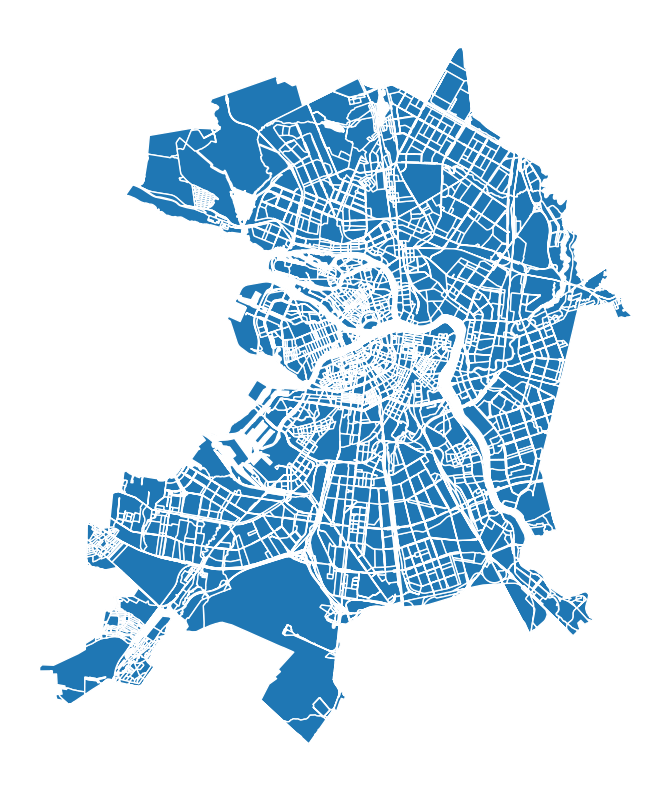

In [5]:
blocks.plot(figsize=(10,10)).set_axis_off()

## BlocksSplitter

In [6]:
from blocksnet import BlocksSplitter

buildings = gpd.read_parquet(os.path.join(example_data_path, 'buildings.parquet')).to_crs(local_crs)
buildings.geometry = buildings.representative_point()

bs = BlocksSplitter(blocks, buildings)

In [7]:
blocks = bs.run()
blocks

2024-07-17 18:56:27.275 | INFO     | blocksnet.preprocessing.blocks_splitter:run:57 - Joining buildings and blocks to exclude duplicates
2024-07-17 18:56:27.764 | INFO     | blocksnet.preprocessing.blocks_splitter:run:66 - Choosing blocks to be splitted
2024-07-17 18:56:28.052 | INFO     | blocksnet.preprocessing.blocks_splitter:run:75 - Splitting filtered blocks
100%|██████████| 166/166 [01:07<00:00,  2.47it/s]


,geometry
0,"POLYGON ((10766.536 6673449.970, 10752.197 667..."
1,"POLYGON ((11432.982 6673681.252, 11388.043 667..."
2,"POLYGON ((10502.076 6673123.291, 10488.963 667..."
3,"POLYGON ((12000.332 6673888.943, 11959.740 667..."
4,"POLYGON ((11623.167 6674088.376, 11626.266 667..."
...,...
11378,"POLYGON ((18108.339 6674415.869, 18106.510 667..."
11379,"POLYGON ((7534.806 6670781.915, 7557.989 66707..."
11380,"POLYGON ((7872.737 6670315.937, 7857.390 66703..."
11381,"POLYGON ((7903.107 6670282.893, 7872.737 66703..."


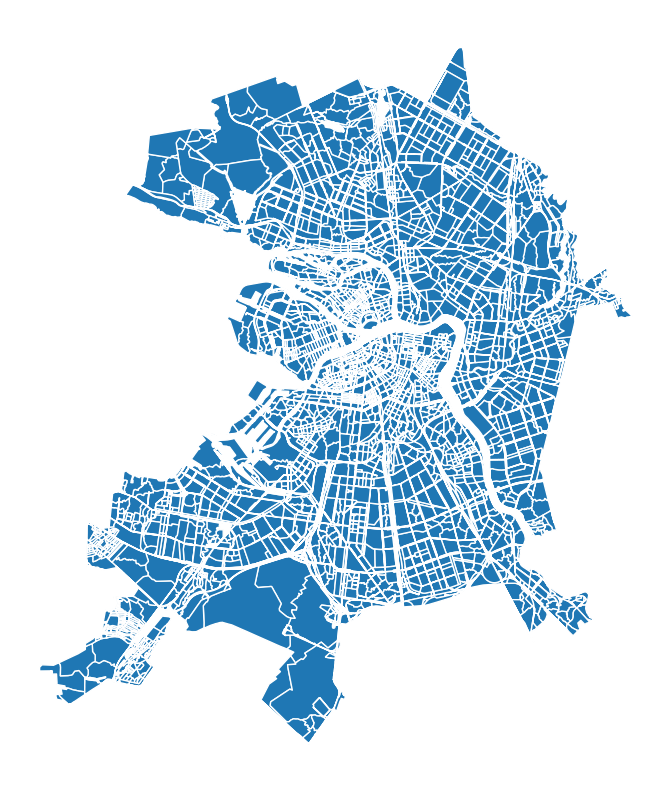

In [8]:
blocks.plot(figsize=(10,10)).set_axis_off()

## LandUseProcessor

In [10]:
from blocksnet import LandUseProcessor

zones = gpd.read_file(os.path.join(example_data_path, "pzz.geojson")).to_crs(local_crs)
lup = LandUseProcessor(blocks=blocks, zones=zones)

In [11]:
blocks = lup.run()

2024-07-17 18:58:40.868 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:183 - Overlaying geometries
2024-07-17 18:58:48.116 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:196 - Finding sum of intersection areas
2024-07-17 18:58:48.139 | INFO     | blocksnet.preprocessing.land_use_proccessor:run:208 - Getting intersecting attributes


Save the result for the next example

In [12]:
blocks.head()

,geometry,zone,land_use
0,"POLYGON ((10766.536 6673449.970, 10752.197 667...",ТИ3,TRANSPORT
1,"POLYGON ((11432.982 6673681.252, 11388.043 667...",ТД2,BUSINESS
2,"POLYGON ((10502.076 6673123.291, 10488.963 667...",ТИ3,TRANSPORT
3,"POLYGON ((12000.332 6673888.943, 11959.740 667...",ТИ4,TRANSPORT
4,"POLYGON ((11623.167 6674088.376, 11626.266 667...",ТИ4,TRANSPORT


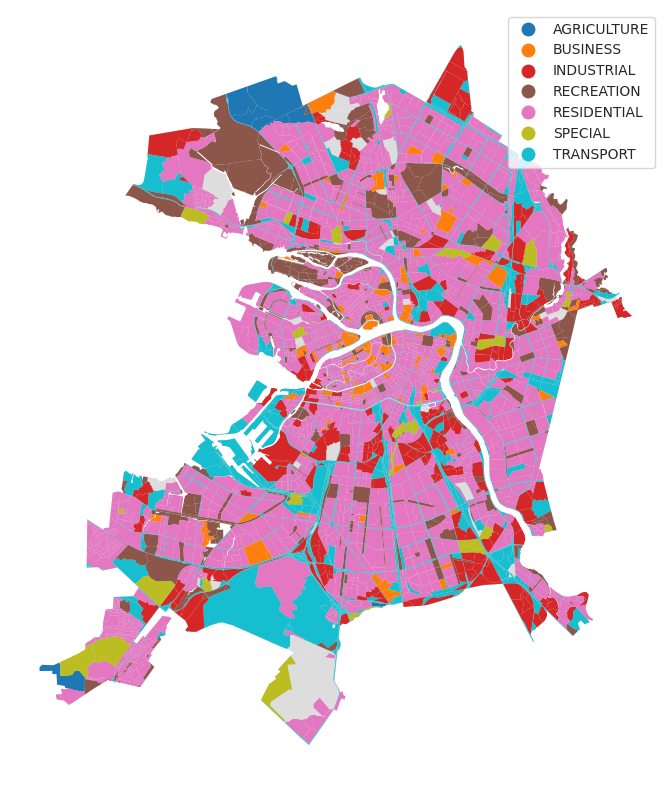

In [15]:
ax = blocks.plot(color='#ddd', figsize=(10,10), linewidth=0)
blocks.plot(column='land_use', legend=True, ax=ax, linewidth=0).set_axis_off()

## Saving the results

In [16]:
blocks.to_parquet(os.path.join(example_data_path, "blocks.parquet"))